In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint

---
Low Rank Matrix Factorization
=====
***

---
###Given: $x^{1}, x^{2}, ..., x^{nm}$, estimate $\theta^{1}, \theta^{2}, ..., \theta^{nu}$ for all users 

###$$\underset{\theta^{1}, \theta^{2}, ..., \theta^{nu}}{\operatorname{min}} \frac{1}{2} \sum_{j=1}^{nu}\sum_{i:r(i, j)==1}(\theta^{jT}x^{i} - y ^{i, j})^{2} + \frac{\lambda}{2}\sum_{j=1}^{nu}\sum_{k=1}^{N}(\theta_{k}^{j})^{2}$$


###Given: $\theta^{1}, \theta^{2}, ..., \theta^{nu}$, estimate $x^{1}, x^{2}, ..., x^{nm}$ for all users 

###$$\underset{\text{ }x^{1}, x^{2}, ..., x^{nm}}{\operatorname{min}} \frac{1}{2} \sum_{i=1}^{nm}\sum_{j:r(i, j)==1}(\theta^{jT}x^{i} - y ^{i, j})^{2} + \frac{\lambda}{2}\sum_{i=1}^{nm}\sum_{k=1}^{N}(x_{k}^{i})^{2}$$
---

---
###Solve for $x$ and $\theta$ simultaneously:


###Define the cost function, $J$, as:

$$J(x^{1}, x^{2}, ..., x^{nm}, \theta^{1}, \theta^{2}, ..., \theta^{nu}) = \frac{1}{2} \sum_{(i, j):r(i, j)==1}(\theta^{jT}x^{i} - y ^{i, j})^{2} + \frac{\lambda}{2}\sum_{i=1}^{nm}\sum_{k=1}^{N}(x_{k}^{i})^{2} + \frac{\lambda}{2}\sum_{j=1}^{nu}\sum_{k=1}^{N}(\theta_{k}^{j})^{2}$$

###and minimize:

$$\underset{\text{ }x^{1}, x^{2}, ..., x^{nm}, \theta^{1}, \theta^{2}, ..., \theta^{nu}}{\operatorname{min}} J(x^{1}, x^{2}, ..., x^{nm}, \theta^{1}, \theta^{2}, ..., \theta^{nu})$$
---

---
###where:
###- $j$ is the user
###- $nu$ is the number of users
###- $nm$ is the number of movies
###- $i$ is the movie
###- $r(i,j) == 1$ if user $j$ has rated movie $i$
###- $\theta^{j}$ is the parameter vector for user $j$
###- $x^{i}$ is the feature vector for movie $i$
###- $y^{i,j}$ is the rating by user $j$ for movie $i$, if user $j$ has rated that movie
###$\frac{\lambda}{2}\sum_{i=1}^{nm}\sum_{k=1}^{N}(x_{k}^{i})^{2}$ and $\frac{\lambda}{2}\sum_{j=1}^{nu}\sum_{k=1}^{N}(\theta_{k}^{j})^{2}$ are the regularization terms for the $x$ and $\theta$ parameters.
---

---
##Gradient Descent Update Equations
---

###$$x_{k}^{i} = x_{k}^{i} - \alpha \left[ \sum_{j:r(i, j)==1}(\theta^{jT}x^{i} - y ^{i, j})\theta_{k}^{j} + \lambda x_{k}^{i} \right]$$

###$$\theta_{k}^{j} = \theta_{k}^{j} - \alpha \left[ \sum_{i:r(i, j)==1}(\theta^{jT}x^{i} - y ^{i, j})x_{k}^{i} + \lambda\theta_{k}^{j} \right]$$


###$\alpha$ is the learning rate
---

#####Let's use our tiny toy database again

In [3]:
data = pd.DataFrame({'Susan':[5,5,-1,0,0], "Mary":[5, -1, 4, 0, 0], "Phil":[0, -1, 0, 5, 5], "Greg":[0, 0, -1, 4, -1],
                    'x1':[0.9, 1.0, 0.99, 0.1, 0.0], 'x2':[0, 0.01, 0, 1.0, 0.9]}\
                   , columns = ['Susan', 'Mary', 'Phil', 'Greg', 'x1', 'x2']
                   , index=["Big", "The Notebook", "Barefoot in the Park", "The Bourne Legacy", "The International"]
                   )
data.index.name = "Movie"
data.columns.name = "User"

In [4]:
data[['Susan', 'Mary', 'Phil', 'Greg']]

User,Susan,Mary,Phil,Greg
Movie,,,,
Big,5,5,0,0
The Notebook,5,-1,-1,0
Barefoot in the Park,-1,4,0,-1
The Bourne Legacy,0,0,5,4
The International,0,0,5,-1


In [13]:
#i indexes the movie, j the user
def r(i, j, data):
    '''This checks to see if the user has reviewed a movie (as indicated by the presence of a -1).
    If they have reviewed the movie then this function returns a 1'''
    
    ulist = data.iloc[i]
    
    #if a -1 is encountered then the movie has not been rated
    if ulist[j] != -1:
        return 1
    else:
        return 0

In [14]:
def y(i, j, data):
    '''This function returns the rating provided by the user for the movie'''
    
    ulist = data.iloc[i]
    return ulist[j]

#####The variable t is used to indicate $\theta$, and $x$ to indicate 'features'

In [15]:
def x_update(alpha, x, t, nk, k, i, nu, nm, data, lam):
    '''This is the partial derivative equation required to update the movie features'''
    
    tsum = 0.0
    #loop over the number of users
    for j in xrange(nu):
        
        #if the movie was reviewed
        if r(i, j, data):
            tt = t[j]
            tt = tt.reshape(nk, 1)
            
            #theta transpose x - y
            temp = np.dot(tt.T, x[i]) - y(i, j, data)
            
            temp1 = temp * t[j][k]
            tsum += temp1
            
    #regularize
    tsum += lam * x[i][k]
    return x[i][k] - alpha * tsum

In [16]:
def t_update(alpha, x, t, nk, k, j, nu, nm, data, lam):
    '''This is the partial derivative equation required to update the user parameters, theta'''
    
    tsum = 0.0
    #loop over the movies
    for i in xrange(nm):
        
        #if the movie was reviewed
        if r(i, j, data):
            tt = t[j]
            tt = tt.reshape(nk, 1)
            
            #theta transpose x - y
            temp = np.dot(tt.T, x[i]) - y(i, j, data)
            
            temp1 = temp * x[i][k]
            tsum += temp1
            
    #regularize
    tsum += lam * t[j][k]
    return t[j][k] - alpha * tsum

In [17]:
def J_Cost(x, t, nk, nu, nm, data, lam):
    '''This is the cost function that we are minimizing with gradient descent'''
    
    tsum = 0.0
    txsum = 0.0
    ttsum = 0.0
    
    #loop over all the movies and all the users
    for i in xrange(nm):
        for j in xrange(nu):
            
            #if a user has reviewed a movie then process
            if r(i, j, data):
                tt = t[j]
                tt = tt.reshape(nk, 1)
                
                #this is the squared error
                temp = (np.dot(tt.T, x[i]) - y(i, j, data)) * (np.dot(tt.T, x[i]) - y(i, j, data))
                
                #the sum of the squared errors is accumulated here
                tsum += temp
                
    #this is the regularization for the movie features, x
    for i in xrange(nm):
        for k in xrange(nk):
            txsum += x[i][k] * x[i][k]   

    #this is the regularization for the user parameters, theta
    for j in xrange(nu):
        for k in xrange(nk):
            ttsum += t[j][k] * t[j][k]
        
    #return the result
    res = (0.5 * tsum) + (lam/2.0 * txsum) + (lam/2.0 * ttsum)
    return res

---
###Putting it all together - Low Rank Matrix Factorization - lrmf
---

In [18]:
def lrmf(nm = 5, nu = 4, nk = 5, n_iterations = 100, alpha = 0.01, lam = 0.1):
    '''This is the routine that will return a feature set for the movies, x, and a parameter set for users, theta
    number of movies is nm
    number of users is nu
    number of features is nk
    the learning rate is alpha
    the regularization parameter (L2) is lam'''
    
    #set up the array for the features, and a temporary array
    x = np.zeros((nm, nk))
    tempx = np.zeros((nm, nk))

    #initialize to small random values
    for a in xrange(nm):
        for b in xrange(nk):
            x[a][b] = (np.random.rand() - 0.5)/10.0

        
    #set up the array for the user parameters, theta, and a temporary array
    t = np.zeros((nu, nk))
    tempt = np.zeros((nu, nk))

    #initialize to small random values
    for a in xrange(nu):
        for b in xrange(nk):
            t[a][b] = (np.random.rand() - 0.5)/10.0

    #A variable to accumulate the cost function
    Jcost = []

    for n in xrange(n_iterations):
    
        Jcos =  J_Cost(x, t, nk, nu, nm, data, lam)
        Jcost.append(Jcos)
    
        #get all the new variables and store them in a temporary variable
        for i in xrange(nm):
            for k in xrange(nk):
                tempx[i][k] = x_update(alpha, x, t, nk, k, i, nu, nm, data, lam)
        
        #get all the new variables and store them in a temporary variable
        for j in xrange(nu):
            for k in xrange(nk):
                tempt[j][k] = t_update(alpha, x, t, nk, k, j, nu, nm, data, lam)
        
        
        #now do the updates
        for i in xrange(nm):
            for k in xrange(nk):
                x[i][k] = tempx[i][k]
        
        for j in xrange(nu):
            for k in xrange(nk):
                t[j][k] = tempt[j][k]
    return(x, t, Jcost)

#####Run the algorithm
#####Because of the way it's been implemented it is slow - very slow - unusably slow
#####In a real application this would need massive optimization

In [20]:
#number of movies
nm = 5

#number of users
nu = 4 

#number of features to use
nk = 5 

#number of iterations for gradient descent
n_iterations = 150

#the learning rate
alpha = 0.01

#the regularization constant
lam = 0.1

x, t, Jcost = lrmf(nm = nm, nu = nu, nk = nk, n_iterations = n_iterations, alpha = alpha, lam = lam)

#####Caluculating the predicted ratings, x . theta_transpose

In [21]:
#take the transpose of the theta matrix
t_transpose = t.T

#take the inner product of x by theta transpose
res = np.dot(x, t_transpose)

#print res
for i in xrange(nm):
    for j in xrange(nu):
        print "{:5.2f}".format(res[i][j]),
    print "\n"

 4.98  4.93 -0.00  0.01 

 4.91  4.83  0.00 -0.00 

 3.96  3.93  0.00  0.02 

-0.01  0.01  5.02  3.87 

 0.01 -0.01  4.88  3.72 



#####Finding similar movies

In [22]:
cs = cosine_similarity(res, res)
for i in xrange(nm):
    for j in xrange(nm):
        print "{:10.3f}".format(cs[i][j]),
    print "\n"

     1.000      1.000      1.000      0.000      0.000 

     1.000      1.000      1.000     -0.000     -0.000 

     1.000      1.000      1.000      0.002      0.002 

     0.000     -0.000      0.002      1.000      1.000 

     0.000     -0.000      0.002      1.000      1.000 



#####plot the cost function against iterations of gradient descent

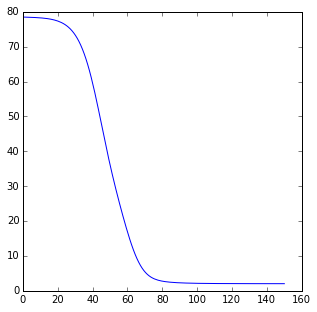

In [23]:
#Plot the cost function over the number of iterations
fig = plt.figure(figsize = (5, 5))
ax = plt.subplot(111)
x_plot = np.linspace(0, n_iterations, n_iterations)
ax.plot(x_plot, Jcost)

In [24]:
#put the results into a data frame
def produce_predicted_dataframe(nu, t, nm, x, k, user_name_list, movie_list):
    '''This function produces a data frame which contains all the predictions from the model'''
    
    #assemble the data in a python dictionary
    p = {}
    
    #take the transpose of the theta matrix
    t_transpose = t.T

    #take the inner product of x by theta transpose
    res = np.dot(x, t_transpose)

    for user in xrange(nu):
        p[user] = res[:,user]
    
    for k in xrange(nk):
        thestr = 'x'+str(int(k))
        p[thestr] = {}
        res = []
        for i in xrange(nm):
            res.append(x[i][k])
        p[thestr] = res
    
    p = pd.DataFrame(p)
    
    p.index.name = "Movie"
    p.columns.name = "User"
    
    for i in xrange(k + 1):
        the_str = 'x' + str(int(i))
        user_name_list.append(the_str)
    p.columns = name_list
    p.index = movie_list
    return p

#####Produce a data frame to compare with the original data frame

In [25]:
#using the original data frame get a list of the users
name_list = []
for j in xrange(nu):
    name_list.append(data.columns.values[j])

#using the original data frame get a list of the movies
movie_list = []
for i in xrange(nm):
    movie_list.append(data.index.values[i])
    
#assemble the data into a data frame
dataP = produce_predicted_dataframe(nu, t, nm, x, nk, name_list, movie_list)

In [29]:
format = lambda x: "{:0.2f}".format(x)

In [30]:
dataP.applymap(format)

,Susan,Mary,Phil,Greg,x0,x1,x2,x3,x4
Big,4.98,4.93,-0.00,0.01,1.01,-1.19,0.12,0.37,1.33
The Notebook,4.91,4.83,0.00,-0.00,0.88,-1.19,0.20,0.33,1.37
Barefoot in the Park,3.96,3.93,0.00,0.02,0.85,-0.92,0.11,0.32,1.04
The Bourne Legacy,-0.01,0.01,5.02,3.87,0.03,1.51,-0.65,0.08,1.36
The International,0.01,-0.01,4.88,3.72,-0.10,1.38,-0.72,0.01,1.36


In [31]:
data

User,Susan,Mary,Phil,Greg,x1,x2
Movie,,,,,,
Big,5,5,0,0,0.90,0.00
The Notebook,5,-1,-1,0,1.00,0.01
Barefoot in the Park,-1,4,0,-1,0.99,0.00
The Bourne Legacy,0,0,5,4,0.10,1.00
The International,0,0,5,-1,0.00,0.90
